In [ ]:
#default_exp tsdata

In [ ]:
#export
from fastai2.torch_basics import *
# from fastai2.test import *
from fastai2.data.all import *

In [ ]:
from nbdev.showdoc import *

In [ ]:
from fastai2.data.external import *

In [ ]:
#export
from zipfile import ZipFile 

# Timeseries - Read data

> Basic functions do read timeseries files like 'arff' and 'ts' files.

## Read '.arff' file

In [ ]:
#export
class TSData():
    "Class that loads .arff (soon .ts) files and returns a tuple (self.x , self.y)"
    "self.x is a list of 2D array with a shape (n_samples, nb_channels, sequence_length) "
    "self.y is a 1D array as y (i.e. label) with a shape (n_samples)"
    "for the NATOPS_Train.arff file, the result will be : x(180, 24, 51) and y(180)"
    def __init__(self):
        self.x = self.y = self.dsname = self.fnames = []
    
    # def __init__(self, fnames, has_targets=True, fill_missing='NaN'):
    #     self.x = self.y = self.dsname = []
    #     self.fnames = fnames
    #     self.has_targets = has_targets
    #     self.fill_missings = fill_missing
    #     # load(fnames, has_targets=has_targets, fill_missing=fill_missing)

    
    
    def __repr__(self): return f"{self.__class__.__name__}:\n Datasets names (concatenated): {self.dsname}\n Filenames: {self.fnames}\n Data shape: {self.x.shape}\n Targets shape: {self.y.shape}\n Nb Samples: {self.x.shape[0]}\n Nb Channels: {self.x.shape[1]}\n Sequence Length: {self.x.shape[2]}"
    
    def get_x(self, as_list=True): return(list(self.x))
    def get_y(self): return(self.y)
    def get_items(self): return [(item, label) for (item, label) in zip(list(self.x), self.y)]
    def __getitem__(self, i): return (self.x[i], self.y[i])
    
    @property
    def sizes(self): return (self.x.shape, self.y.shape)
    
    @property
    def n_channels(self): return (self.x.shape[1])
    
    def _load(self, fname, has_targets=True, fill_missing='NaN'):
        "load an .arff file and return a tupple of 2 numpy arrays: "
        "x : array with a shape (n_samples, nb_channels, sequence_length)"
        "y : array with a shape (n_samples)"
        "for the NATOPS_Train.arff  the result will be : x(180, 24, 51) and y(180)"
        
        instance_list = []
        class_val_list = []
        data_started = False
        is_multi_variate = False
        is_first_case = True
        
        with open(fname, 'r') as f:
            for line in f:
                if line.strip():
                    if is_multi_variate is False and "@attribute" in line.lower() and "relational" in line.lower():
                        is_multi_variate = True
                    if "@data" in line.lower():
                        data_started = True
                        continue
                    # if the 'data tag has been found, the header information has been cleared and now data can be loaded
                    if data_started:
                        line = line.replace("?", fill_missing)
                        if is_multi_variate:
                            if has_targets:
                                line, class_val = line.split("',")
                                class_val_list.append(class_val.strip())
                            dimensions = line.split("\\n")
                            dimensions[0] = dimensions[0].replace("'", "")

                            if is_first_case:
                                for d in range(len(dimensions)):
                                    instance_list.append([])
                                is_first_case = False

                            for dim in range(len(dimensions)):
                                instance_list[dim].append(np.array(dimensions[dim].split(','), dtype=np.float32))
#                                 instance_list[dim].append(np.fromiter(dimensions[dim].split(','), dtype=np.float32))
                        else:
                            if is_first_case:
                                instance_list.append([])
                                is_first_case = False

                            line_parts = line.split(",")

                            if has_targets:
                                instance_list[0].append(np.array(line_parts[:len(line_parts)-1], dtype=np.float32))

                                class_val_list.append(line_parts[-1].strip())
                            else:
                                instance_list[0].append(np.array(line_parts[:len(line_parts)-1], dtype=np.float32))

        #instance_list has a shape of (dimensions, nb_samples, seq_lenght)
        #for the NATOPS_Train.arff it would be (24, 180, 51)
        #convert python list to numpy array and transpose the 2 first dimensions -> (180, 24, 51)
        x = np.asarray(instance_list).transpose(1,0,2) 
        y = np.asarray(class_val_list)       
        return x, y

    def load(self, fnames, has_targets=True, fill_missing='NaN'):
        if isinstance(fnames, list):
            self.x = []
            self.y = []
            self.dsname = []
            self.fnames = []
            xs,ys = [],[]
            for i, fn in enumerate(fnames): 
                x,y = self._load(fn, has_targets=has_targets, fill_missing=fill_missing)
                xs.append(x)
                ys.append(y)
                self.fnames.append(fn)
                self.dsname.append(fn.stem)
            self.x = np.concatenate(xs)
            self.y = np.concatenate(ys)
        else:
            self.fnames.append(fnames)
            self.dsname.append(fnames.stem)
            self.x, self.y = self._load(fnames, has_targets=has_targets, fill_missing=fill_missing)
        
        return (self.x, self.y)    
    


In [ ]:
show_doc(TSData)

<h2 id="TSData" class="doc_header"><code>class</code> <code>TSData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>TSData</code>()

Class that loads .arff (soon .ts) files and returns a tuple (self.x , self.y)

In [ ]:
show_doc(TSData.load)

<h4 id="TSData.load" class="doc_header"><code>TSData.load</code><a href="__main__.py#L91" class="source_link" style="float:right">[source]</a></h4>

> <code>TSData.load</code>(**`fnames`**, **`has_targets`**=*`True`*, **`fill_missing`**=*`'NaN'`*)



## Plot Timeseries

In [ ]:
#export
def show_timeseries(ts, ctx=None, title=None, chs=None, leg=True, **kwargs):
    r"""
    Plot a timeseries.

    Args:
      title : usually the class of the timeseries
      ts : timeseries. It should have a shape of (nb_channels, sequence_length)
      chs : array representing a list of channels to plot
      leg : Display or not a legend
    """

    if ctx is None: fig, ctx = plt.subplots()
    t = range(ts.shape[1])
    chs_max = max(chs) if chs else 0
    channels = chs if (chs and (chs_max < ts.shape[0])) else range(ts.shape[0]) 
    for ch in channels:
        ctx.plot(t, ts[ch], label='ch'+str(ch))
    if leg: ctx.legend(loc='upper right', ncol=2, framealpha=0.5)
    if title: ctx.set_title(title)
    return ctx

In [ ]:
show_doc(show_timeseries)

<h4 id="show_timeseries" class="doc_header"><code>show_timeseries</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>show_timeseries</code>(**`ts`**, **`ctx`**=*`None`*, **`title`**=*`None`*, **`chs`**=*`None`*, **`leg`**=*`True`*, **\*\*`kwargs`**)

Plot a timeseries.

Args:
  title : usually the class of the timeseries
  ts : timeseries. It should have a shape of (nb_channels, sequence_length)
  chs : array representing a list of channels to plot
  leg : Display or not a legend

In [ ]:
path_data = Config().data
path_data

Path('C:/Users/fh/.fastai/data')

In [ ]:
path_data

Path('C:/Users/fh/.fastai/data')

In [ ]:
#export
def download_unzip_data(url=None, path_data=None, dsname=None, c_key='archive', force_download=False):
    if url is None:
        print(f'Please enter a valid ${url} to a dataset to be downloaded')
        return None
    
    if dsname is None:
        print(f'Please enter a valid ${dsname} of the dataset name to be downloaded')
        return None


    "Download `url` to `path_data/dsname` folder."
    url_file = url + dsname + '.zip' #url_file = 'http://www.timeseriesclassification.com/Downloads/NATOPS.zip'
    dest_fname = path_data/f'{dsname}.zip'
    dest_dir = path_data/dsname # same name as the filename
    
    if not dest_fname.exists() or force_download: 
        download_url(url_file, dest_fname, overwrite=force_download)
        unzip(dest_fname, dest_dir)
    return dest_dir

def unzip(dsname, dest_dir, verbose=False):    
    with ZipFile(dsname, 'r') as zip: 
        if verbose:
            zip.printdir() 
            print(f'Extracting all the files from : {dsname}')       
        zip.extractall(path=dest_dir) 

def download_unzip_data_UCR(path_data=None, dsname=None, c_key='archive', force_download=False):
    url = 'http://www.timeseriesclassification.com/Downloads/'
    if path_data is None: path_data = Config().data
    
    return download_unzip_data(url=url, path_data=path_data, dsname=dsname, c_key=c_key, force_download=force_download)

In [ ]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'
url = 'http://www.timeseriesclassification.com/Downloads/' 

url, path_data, dsname, 

('http://www.timeseriesclassification.com/Downloads/',
 Path('C:/Users/fh/.fastai/data'),
 'NATOPS')

In [ ]:
path = download_unzip_data(url, path_data=path_data, dsname=dsname, c_key='archive', force_download=False)
path

Path('C:/Users/fh/.fastai/data/NATOPS')

In [ ]:
path2 = download_unzip_data(url=None, path_data=path_data, dsname=dsname, c_key='archive', force_download=False)
path2

Please enter a valid $None to a dataset to be downloaded


In [ ]:
path = download_unzip_data_UCR(dsname=dsname)
path

Path('C:/Users/fh/.fastai/data/NATOPS')

In [ ]:
fname_train = path_data/f'{dsname}/{dsname}_Train.arff'
fname_test = path_data/f'{dsname}/{dsname}_Test.arff'
fnames = [fname_train, fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'),
 Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]

In [ ]:
# o = TSData([fname_train, fname_test])
# type(o), o.__dict__

In [ ]:
data = TSData()
train_x, train_y = data.load([fname_train, fname_test])
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_Train', 'NATOPS_Test']
 Filenames: [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'), Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels: 24
 Sequence Length: 51


In [ ]:
data.dsname, data.fnames, data.n_channels, data.sizes, data.x.shape, data.y.shape

(['NATOPS_Train', 'NATOPS_Test'],
 [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'),
  Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')],
 24,
 ((360, 24, 51), (360,)),
 (360, 24, 51),
 (360,))

In [ ]:
test_eq(data.dsname, ['NATOPS_Train', 'NATOPS_Test'])
test_eq(data.n_channels, 24)
test_eq(data.sizes, ((360, 24, 51), (360,)))
test_eq(data.x.shape, (360, 24, 51))
test_eq(data.y.shape, (360,))

In [ ]:
type(data.get_items()[1][0]), data.get_items()[1][0]

(numpy.ndarray,
 array([[-0.54737 , -0.546334, -0.549748, ..., -0.533726, -0.528338,
         -0.518618],
        [-1.600105, -1.599419, -1.595734, ..., -1.576063, -1.572246,
         -1.565955],
        [-0.809446, -0.80942 , -0.812398, ..., -0.766209, -0.764902,
         -0.765835],
        ...,
        [ 0.618919,  0.648665,  0.618913, ...,  0.455396,  0.457002,
          0.456688],
        [-1.497652, -1.465919, -1.50323 , ..., -1.435609, -1.422537,
         -1.421817],
        [-0.754927, -0.706829, -0.758939, ..., -0.538306, -0.530174,
         -0.529384]], dtype=float32))

In [ ]:
data.get_y()[1]

'3.0'

In [ ]:
test_eq(data.get_y()[1], '3.0')

In [ ]:
chs=range(0,24,3)
list(chs)

[0, 3, 6, 9, 12, 15, 18, 21]

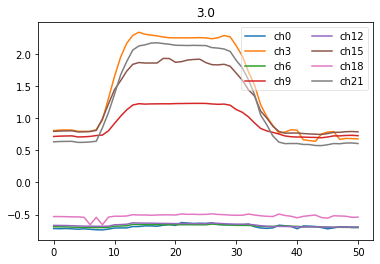

In [ ]:
idx = 4
ts, title = train_x[idx], train_y[idx]
show_timeseries(ts, title=title, chs=range(0,24,3)) 
# show_timeseries(ts, title=title)

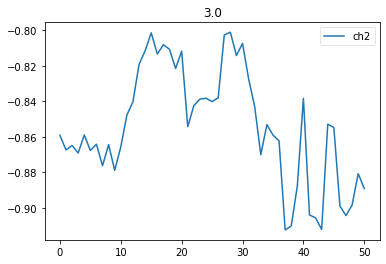

In [ ]:
show_timeseries(ts, title=title, chs=[2]) 

## Read '.ts' file into 3D array

In [ ]:
def load_from_tsfile_to_array(full_file_path_and_name, return_separate_X_and_y=True, replace_missing_vals_with='NaN'):
    """Loads data from a .ts file into a Pandas DataFrame.

    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    return_separate_X_and_y: bool
        true if X and Y values should be returned as separate Data Frames (X) and a numpy array (y), false otherwise.
        This is only relevant for data that
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced with prior to parsing.

    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a numpy array containing the relevant time-series and corresponding class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing all time-series and (if relevant) a column "class_vals" the associated class values.
    """

    # Initialize flags and variables used when parsing the file

    metadata_started = False
    data_started = False

    has_problem_name_tag = False
    has_timestamps_tag = False
    has_univariate_tag = False
    has_class_labels_tag = False
    has_data_tag = False

    previous_timestamp_was_int = None
    previous_timestamp_was_timestamp = None
    num_dimensions = None
    is_first_case = True
    instance_list = []
    class_val_list = []
    line_num = 0

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, 'r',encoding='utf-8') as file:
        for line in file:
            # Strip white space from start/end of line and change to lowercase for use below
            line = line.strip().lower()
            # Empty lines are valid at any point in a file
            if line:
                # Check if this line contains metadata
                # Please note that even though metadata is stored in this function it is not currently published externally
                if line.startswith("@problemname"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")
                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("problemname tag requires an associated value")

                    problem_name = line[len("@problemname") + 1:]
                    has_problem_name_tag = True
                    metadata_started = True

                elif line.startswith("@timestamps"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len != 2:
                        raise TsFileParseException("timestamps tag requires an associated Boolean value")

                    elif tokens[1] == "true":
                        timestamps = True

                    elif tokens[1] == "false":
                        timestamps = False

                    else:
                        raise TsFileParseException("invalid timestamps value")

                    has_timestamps_tag = True
                    metadata_started = True

                elif line.startswith("@univariate"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len != 2:
                        raise TsFileParseException("univariate tag requires an associated Boolean value")

                    elif tokens[1] == "true":
                        univariate = True

                    elif tokens[1] == "false":
                        univariate = False

                    else:
                        raise TsFileParseException("invalid univariate value")

                    has_univariate_tag = True
                    metadata_started = True

                elif line.startswith("@classlabel"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("classlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        class_labels = True

                    elif tokens[1] == "false":
                        class_labels = False

                    else:
                        raise TsFileParseException("invalid classLabel value")

                    # Check if we have any associated class values

                    if token_len == 2 and class_labels:
                        raise TsFileParseException("if the classlabel tag is true then class values must be supplied")

                    has_class_labels_tag = True
                    class_label_list = [token.strip() for token in tokens[2:]]
                    metadata_started = True

                # Check if this line contains the start of data

                elif line.startswith("@data"):

                    if line != "@data":
                        raise TsFileParseException("data tag should not have an associated value")

                    if data_started and not metadata_started:
                        raise TsFileParseException("metadata must come before data")

                    else:
                        has_data_tag = True
                        data_started = True

                # If the 'data tag has been found then metadata has been parsed and data can be loaded

                elif data_started:

                    # Check that a full set of metadata has been provided

                    if not has_problem_name_tag or not has_timestamps_tag or not has_univariate_tag or not has_class_labels_tag or not has_data_tag:
                        raise TsFileParseException("a full set of metadata has not been provided before the data")

                    # Replace any missing values with the value specified

                    line = line.replace("?", replace_missing_vals_with)

                    # Check if we dealing with data that has timestamps

                    if timestamps:

                        # We're dealing with timestamps so cannot just split line on ':' as timestamps may contain one

                        has_another_value = False
                        has_another_dimension = False

                        timestamps_for_dimension = []
                        values_for_dimension = []

                        this_line_num_dimensions = 0
                        line_len = len(line)
                        char_num = 0

                        while char_num < line_len:

                            # Move through any spaces

                            while char_num < line_len and str.isspace(line[char_num]):
                                char_num += 1

                            # See if there is any more data to read in or if we should validate that read thus far

                            if char_num < line_len:

                                # See if we have an empty dimension (i.e. no values)

                                if line[char_num] == ":":
                                    if len(instance_list) < (this_line_num_dimensions + 1):
                                        instance_list.append([])

                                    instance_list[this_line_num_dimensions].append(pd.Series())
                                    this_line_num_dimensions += 1

                                    has_another_value = False
                                    has_another_dimension = True

                                    timestamps_for_dimension = []
                                    values_for_dimension = []

                                    char_num += 1

                                else:

                                    # Check if we have reached a class label

                                    if line[char_num] != "(" and class_labels:

                                        class_val = line[char_num:].strip()

                                        if class_val not in class_label_list:
                                            raise TsFileParseException("the class value '" + class_val + "' on line " + str(line_num + 1) + " is not valid")

                                        class_val_list.append(class_val)
                                        char_num = line_len

                                        has_another_value = False
                                        has_another_dimension = False

                                        timestamps_for_dimension = []
                                        values_for_dimension = []

                                    else:

                                        # Read in the data contained within the next tuple

                                        if line[char_num] != "(" and not class_labels:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " does not start with a '('")

                                        char_num += 1
                                        tuple_data = ""

                                        while char_num < line_len and line[char_num] != ")":
                                            tuple_data += line[char_num]
                                            char_num += 1

                                        if char_num >= line_len or line[char_num] != ")":
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " does not end with a ')'")

                                        # Read in any spaces immediately after the current tuple

                                        char_num += 1

                                        while char_num < line_len and str.isspace(line[char_num]):
                                            char_num += 1

                                        # Check if there is another value or dimension to process after this tuple

                                        if char_num >= line_len:
                                            has_another_value = False
                                            has_another_dimension = False

                                        elif line[char_num] == ",":
                                            has_another_value = True
                                            has_another_dimension = False

                                        elif line[char_num] == ":":
                                            has_another_value = False
                                            has_another_dimension = True

                                        char_num += 1

                                        # Get the numeric value for the tuple by reading from the end of the tuple data backwards to the last comma

                                        last_comma_index = tuple_data.rfind(',')

                                        if last_comma_index == -1:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " contains a tuple that has no comma inside of it")

                                        try:
                                            value = tuple_data[last_comma_index + 1:]
                                            value = float(value)

                                        except ValueError:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " contains a tuple that does not have a valid numeric value")

                                        # Check the type of timestamp that we have

                                        timestamp = tuple_data[0: last_comma_index]

                                        try:
                                            timestamp = int(timestamp)
                                            timestamp_is_int = True
                                            timestamp_is_timestamp = False

                                        except ValueError:
                                            timestamp_is_int = False

                                        if not timestamp_is_int:
                                            try:
                                                timestamp = timestamp.strip()
                                                timestamp_is_timestamp = True

                                            except ValueError:
                                                timestamp_is_timestamp = False

                                        # Make sure that the timestamps in the file (not just this dimension or case) are consistent

                                        if not timestamp_is_timestamp and not timestamp_is_int:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " contains a tuple that has an invalid timestamp '" + timestamp + "'")

                                        if previous_timestamp_was_int is not None and previous_timestamp_was_int and not timestamp_is_int:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " contains tuples where the timestamp format is inconsistent")

                                        if previous_timestamp_was_timestamp is not None and previous_timestamp_was_timestamp and not timestamp_is_timestamp:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " contains tuples where the timestamp format is inconsistent")

                                        # Store the values

                                        timestamps_for_dimension += [timestamp]
                                        values_for_dimension += [value]

                                        #  If this was our first tuple then we store the type of timestamp we had

                                        if previous_timestamp_was_timestamp is None and timestamp_is_timestamp:
                                            previous_timestamp_was_timestamp = True
                                            previous_timestamp_was_int = False

                                        if previous_timestamp_was_int is None and timestamp_is_int:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = True

                                        # See if we should add the data for this dimension

                                        if not has_another_value:
                                            if len(instance_list) < (this_line_num_dimensions + 1):
                                                instance_list.append([])

                                            if timestamp_is_timestamp:
                                                timestamps_for_dimension = pd.DatetimeIndex(timestamps_for_dimension)

                                            instance_list[this_line_num_dimensions].append(pd.Series(index=timestamps_for_dimension, data=values_for_dimension))
                                            this_line_num_dimensions += 1

                                            timestamps_for_dimension = []
                                            values_for_dimension = []

                            elif has_another_value:
                                raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " ends with a ',' that is not followed by another tuple")

                            elif has_another_dimension and class_labels:
                                raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " ends with a ':' while it should list a class value")

                            elif has_another_dimension and not class_labels:
                                if len(instance_list) < (this_line_num_dimensions + 1):
                                    instance_list.append([])

                                instance_list[this_line_num_dimensions].append(pd.Series(dtype=np.float32))
                                this_line_num_dimensions += 1
                                num_dimensions = this_line_num_dimensions

                            # If this is the 1st line of data we have seen then note the dimensions

                            if not has_another_value and not has_another_dimension:
                                if num_dimensions is None:
                                    num_dimensions = this_line_num_dimensions

                                if num_dimensions != this_line_num_dimensions:
                                    raise TsFileParseException("line " + str(line_num + 1) + " does not have the same number of dimensions as the previous line of data")

                        # Check that we are not expecting some more data, and if not, store that processed above

                        if has_another_value:
                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " ends with a ',' that is not followed by another tuple")

                        elif has_another_dimension and class_labels:
                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + " on line " + str(line_num + 1) + " ends with a ':' while it should list a class value")

                        elif has_another_dimension and not class_labels:
                            if len(instance_list) < (this_line_num_dimensions + 1):
                                instance_list.append([])

                            instance_list[this_line_num_dimensions].append(pd.Series())
                            this_line_num_dimensions += 1
                            num_dimensions = this_line_num_dimensions

                        # If this is the 1st line of data we have seen then note the dimensions

                        if not has_another_value and num_dimensions != this_line_num_dimensions:
                            raise TsFileParseException("line " + str(line_num + 1) + " does not have the same number of dimensions as the previous line of data")

                        # Check if we should have class values, and if so that they are contained in those listed in the metadata

                        if class_labels and len(class_val_list) == 0:
                            raise TsFileParseException("the cases have no associated class values")

                    else:
                        dimensions = line.split(":")

                        # If first row then note the number of dimensions (that must be the same for all cases)

                        if is_first_case:
                            num_dimensions = len(dimensions)

                            if class_labels:
                                num_dimensions -= 1

                            for dim in range(0, num_dimensions):
                                instance_list.append([])

                            is_first_case = False

                        # See how many dimensions that the case whose data in represented in this line has

                        this_line_num_dimensions = len(dimensions)

                        if class_labels:
                            this_line_num_dimensions -= 1

                        # All dimensions should be included for all series, even if they are empty

                        if this_line_num_dimensions != num_dimensions:
                            raise TsFileParseException("inconsistent number of dimensions")

                        # Process the data for each dimension

                        for dim in range(0, num_dimensions):
                            dimension = dimensions[dim].strip()

                            if dimension:
#                                 data_series = dimension.split(",")
#                                 data_series = [float(i) for i in data_series]
#                                 instance_list[dim].append(pd.Series(data_series))
                                
#                                 instance_list[dim].append(np.array(dimensions[dim].strip().split(','), dtype=np.float32))
                                instance_list[dim].append(np.array(dimensions[dim].split(','), dtype=np.float32))
#                                 instance_list[dim].append(np.fromiter(dimensions[dim].strip().split(','), dtype=np.float32))

                            else:
#                                 instance_list[dim].append(pd.Series())
                                instance_list[dim].append([])

                        if class_labels:
                            class_val_list.append(dimensions[num_dimensions].strip())

            line_num += 1

    # Check that the file was not empty

    if line_num:
        # Check that the file contained both metadata and data

        if metadata_started and not (has_problem_name_tag and has_timestamps_tag and has_univariate_tag and has_class_labels_tag and has_data_tag):
            raise TsFileParseException("metadata incomplete")

        elif metadata_started and not data_started:
            raise TsFileParseException("file contained metadata but no data")

        elif metadata_started and data_started and len(instance_list) == 0:
            raise TsFileParseException("file contained metadata but no data")

#         # Create a DataFrame from the data parsed above

#         data = pd.DataFrame(dtype=np.float32)

#         for dim in range(0, num_dimensions):
#             data['dim_' + str(dim)] = instance_list[dim]

#         # Check if we should return any associated class labels separately

#         if class_labels:
#             if return_separate_X_and_y:
#                 return data, np.asarray(class_val_list)

#             else:
#                 data['class_vals'] = pd.Series(class_val_list)
#                 return data
#         else:
#             return data

        
        # Create a numpy array
            
        #instance_list has a shape of (dimensions, nb_samples, seq_lenght)
        #for the NATOPS_Train.arff it would be (24, 180, 51)
        #convert python list to numpy array and traspose the 2 first dimensions -> (180, 24, 51)
        data_array = np.asarray(instance_list).transpose(1,0,2) 
        y = np.asarray(class_val_list)

        return data_array, y
    

    else:
        raise TsFileParseException("empty file")


In [ ]:
fname_train = path_data/f'{dsname}/{dsname}_Train.ts'
fname_train

Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.ts')

In [ ]:
train_x_ts, train_y_ts = load_from_tsfile_to_array(fname_train)
train_x_ts.shape, train_y_ts.shape

((180, 24, 51), (180,))

In [ ]:
train_x[1].shape

(24, 51)

In [ ]:
train_x[10][0][30], train_x_ts[10][0][30]

(0.445743, 0.445743)

In [ ]:
#export
def get_UCR_univariate_list():
    return [
        'ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY',
        'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken',
        'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration',
        'CinCECGtorso', 'Coffee', 'Computers', 'CricketX', 'CricketY',
        'CricketZ', 'Crop', 'DiatomSizeReduction',
        'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect',
        'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame',
        'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays',
        'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal',
        'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords',
        'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain',
        'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3',
        'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan',
        'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham',
        'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate',
        'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound',
        'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2',
        'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian',
        'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect',
        'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain',
        'MoteStrain', 'NonInvasiveFetalECGThorax1',
        'NonInvasiveFetalECGThorax2', 'OliveOil', 'OSULeaf',
        'PhalangesOutlinesCorrect', 'Phoneme', 'PickupGestureWiimoteZ',
        'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'PLAID', 'Plane',
        'PowerCons', 'ProximalPhalanxOutlineAgeGroup',
        'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW',
        'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2',
        'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ',
        'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace',
        'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarlightCurves',
        'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl',
        'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG',
        'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll', 'UWaveGestureLibraryX',
        'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Wine',
        'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga'
    ]

def get_UCR_multivariate_list():
    return [
        'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions',
        'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms',
        'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection',
        'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat',
        'JapaneseVowels', 'Libras', 'LSST', 'InsectWingbeat', 'MotorImagery',
        'NATOPS', 'PenDigits', 'PEMS-SF', 'PhonemeSpectra', 'RacketSports',
        'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits',
        'StandWalkJump', 'UWaveGestureLibrary'
    ]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
# notebook2script(fname='80_timeseries_data.ipynb')

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted index.ipynb.
